In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt




In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 299


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Leaf_dataset/",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
labels = dataset.class_names
labels

Found 7125 files belonging to 25 classes.


['Alstonia Scholaris (P2)',
 'Apple',
 'Apta',
 'Arjun (P1)',
 'Chinar (P11)',
 'Eggplant',
 'Gauva (P3)',
 'Groundnut',
 'Indian Rubber Tree',
 'Jamun (P5)',
 'Jatropha (P6)',
 'Karanj',
 'Kashid',
 'Lemon',
 'Mango',
 'Nilgiri',
 'Pimpal',
 'Pomegranate',
 'Pongamia Pinnata (P7)',
 'Sita Ashok',
 'Sonmohar',
 'Vad',
 'Vilayati Chinch',
 'beans',
 'sugarcane']

In [4]:
import numpy as np

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    break

(32, 299, 299, 3)
[20  1  2 20 21  7 13 22 11  4 15  7 17 22 17 22 12  7  6 16 22  3 11  2
 19  9  9 15  4 19  7  9]


In [5]:
# train test split
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = int(0.1 * len(dataset))
train_size, test_size, val_size


(178, 22, 22)

In [7]:

def get_dataset_partisions_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * len(ds))
    test_size = int(test_split * len(ds))
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    val_ds = test_ds.skip(test_size)
    test_ds = test_ds.take(test_size)
    return train_ds, test_ds, val_ds

In [8]:
train_ds, test_ds, val_ds = get_dataset_partisions_tf(dataset)
len(train_ds), len(test_ds), len(val_ds)

(178, 22, 23)

In [ ]:
#  Augmentation 
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,                  # Random rotation
    width_shift_range=0.2,              # Random horizontal shift
    height_shift_range=0.2,             # Random vertical shift
    shear_range=0.2,                    # Random shear
    zoom_range=0.2,                     # Random zoom
    horizontal_flip=True,               # Random horizontal flip
    fill_mode='nearest'                 # Fill missing pixels
)

In [ ]:
# Augment training data
train_ds = datagen.flow_from_directory(
    'Leaf_dataset/train', 
    target_size=(299, 299), 
    batch_size=32, 
    class_mode='sparse'
)


In [9]:

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(299, 299),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])



In [10]:
# train using Xception
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(299, 299, 3),
    include_top=False,
    pooling='avg',
    classifier_activation='softmax',
    classes=len(labels)
)

In [11]:

    base_model.trainable = False

inputs = tf.keras.Input(shape=(299, 299, 3))
x = resize_and_rescale(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                3225      
                                                                 
Total params: 21126977 (80.59 MB)
Trainable params: 265497 (1

In [15]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=15
)

Epoch 1/15


178/178 [==============================] - 847s 4s/step - loss: 0.9569 - accuracy: 0.7539 - val_loss: 0.2679 - val_accuracy: 0.9524
Epoch 2/15
178/178 [==============================] - 854s 4s/step - loss: 0.2768 - accuracy: 0.9281 - val_loss: 0.1393 - val_accuracy: 0.9715
Epoch 3/15
178/178 [==============================] - 846s 4s/step - loss: 0.1685 - accuracy: 0.9537 - val_loss: 0.1038 - val_accuracy: 0.9823
Epoch 4/15
178/178 [==============================] - 870s 4s/step - loss: 0.1327 - accuracy: 0.9643 - val_loss: 0.0676 - val_accuracy: 0.9864
Epoch 5/15
178/178 [==============================] - 905s 5s/step - loss: 0.0942 - accuracy: 0.9775 - val_loss: 0.0509 - val_accuracy: 0.9890
Epoch 6/15
178/178 [==============================] - 915s 5s/step - loss: 0.0860 - accuracy: 0.9747 - val_loss: 0.0355 - val_accuracy: 0.9946
Epoch 7/15
178/178 [==============================] - 912s 5s/step - loss: 0.0633 - accuracy: 0.9837 - val_loss: 0.0365 - val_accuracy: 0.99

In [ ]:

model.evaluate(test_ds)

In [ ]:
model.evaluate(val_ds)

In [61]:
# predict with new images7


import numpy as np

img = tf.keras.preprocessing.image.load_img(
    'Samples/Pongamia Pinnata (P7) (2).jpg', target_size=(299, 299)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch


predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 153ms/step
This image most likely belongs to Pongamia Pinnata (P7) with a 72.52 percent confidence.


In [21]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    labels = dataset.class_names
    predictions = model.predict(img_array)

    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence



1/1 [==============================] - 0s 202ms/step


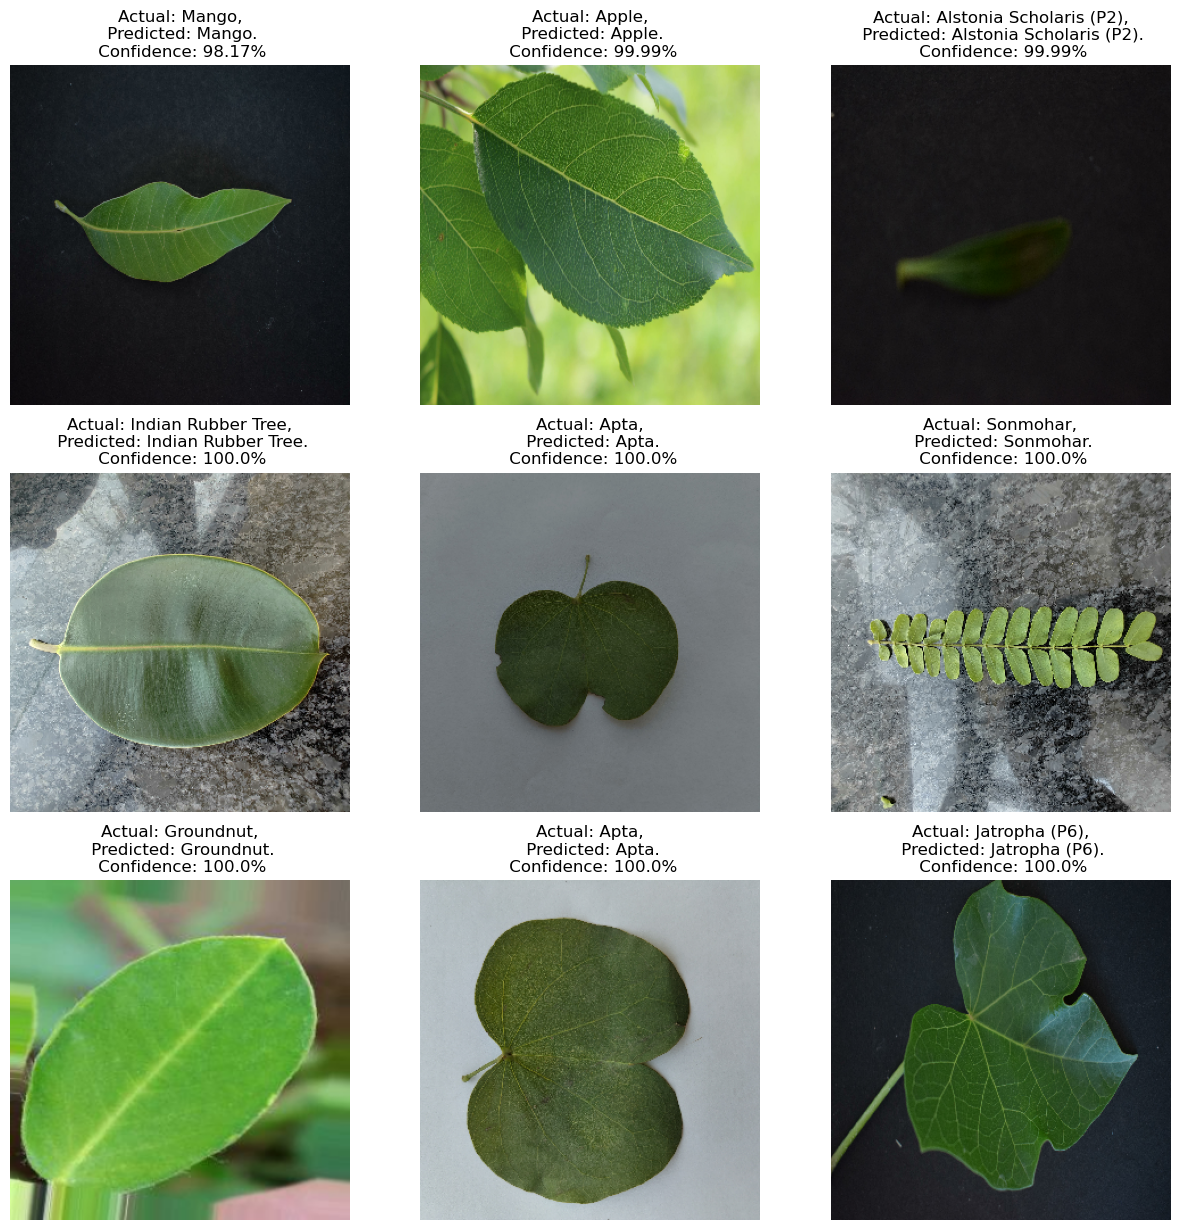

In [22]:
labels = dataset.class_names
plt.figure(figsize=(15, 15))
for images, label in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = labels[label[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

first image to predict
actual label: Nilgiri
1/1 [==============================] - 9s 9s/step
predicted label: Nilgiri


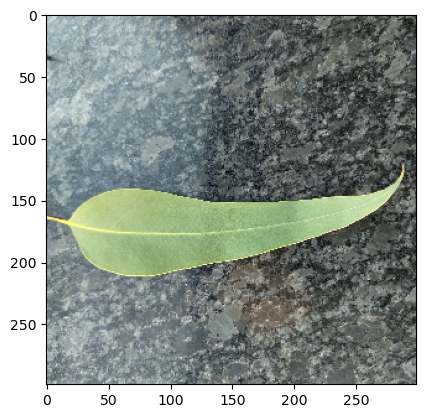

In [223]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    labels = dataset.class_names  
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",labels[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",labels[np.argmax(batch_prediction[0])])       

Selected image to predict


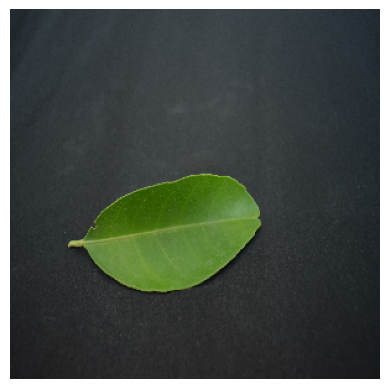

Actual label: Lemon
1/1 [==============================] - 3s 3s/step
Predicted label: Lemon


In [221]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming class_names is defined as follows (replace with your actual class names):
labels = dataset.class_names

def predict_image(index, test_ds, model, labels):
    # Retrieve a batch of images and labels from the test dataset
    for images_batch, labels_batch in test_ds.take(1):
        # Select the image and label at the specified index
        selected_image = images_batch[index].numpy().astype('uint8')
        selected_label = labels_batch[index].numpy()

        # Display the selected image
        print("Selected image to predict")
        plt.imshow(selected_image)
        plt.axis('off')
        plt.show()
        
        # Print the actual label
        print("Actual label:", labels[selected_label])

        # Make a prediction for the selected image
        prediction = model.predict(np.expand_dims(selected_image, axis=0))
        predicted_label = labels[np.argmax(prediction[0])]
        
        # Print the predicted label
        print("Predicted label:", predicted_label)
        
        return selected_image, selected_label, predicted_label

# Example usage
index = 30  # Change this index to select a different image from the batch

# Call the function to predict and display the result for the selected image
selected_image, actual_label, predicted_label = predict_image(index, test_ds, model, labels)


1/1 [==============================] - 1s 534ms/step
Actual label: lemon(P10).jpg 
 This image most likely belongs to Lemon with a 73.10 percent confidence.


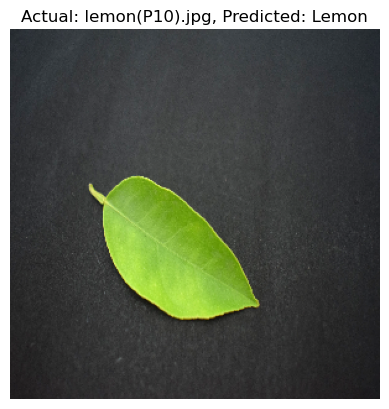

In [224]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
labels=dataset.class_names
def get_actual_label_from_path(image_path):
    # Extract the label from the image path assuming the format 'Samples/Label (X).jpg'
    return os.path.basename(image_path).split()[0]

# Path to the image
image_path = 'Samples/lemon(P10).jpg'

# Extract actual label from the file path
actual_label = get_actual_label_from_path(image_path)

# Load and preprocess the image
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])

# Print the prediction result
print(
    "Actual label: {} \n This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(actual_label, labels[np.argmax(score)], 100 * np.max(score))
)

# Display the image
plt.imshow(tf.keras.preprocessing.image.array_to_img(img_array[0]))
plt.title(f"Actual: {actual_label}, Predicted: {labels[np.argmax(score)]}")
plt.axis('off')
plt.show()


In [26]:
model.save('Leaves.h5')

C:\Users\PMLS\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
